# Data & Imports

In [1]:
# Import libraries
import os
root = os.path.dirname(os.getcwd())
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [53]:
# Load the CIFAR-10 dataset and take a 5000 sample subset
# Train set
# Load Full CIFAR-10 Dataset (Without Transform)
full_trainset = torchvision.datasets.CIFAR10(root=root + '/data', train=True, download=True, transform=None)

# Shuffle dataset before splitting
indices = torch.randperm(len(full_trainset))
full_trainset = torch.utils.data.Subset(full_trainset, indices)

# Take a 5000-sample subset
trainset = torch.utils.data.Subset(full_trainset, range(5000))  # No transform yet
trainloader = DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)  # For normal training

# Take a 1000-sample subset for testing
testset = torch.utils.data.Subset(full_trainset, range(5000, 6000))  # No transform yet
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)  # For normal testing

We create a CustomDataset class to contain our 5000 cifar-10 subsample.

In [10]:
class CustomDataset(torch.utils.data.Dataset):
    """ Wrapper dataset that applies transforms to a given subset """
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        img, label = self.subset[index]
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.subset)

We define a transform function that performs data augmentation **on the fly** during training.

This allows the model to see different variations of the pictures. This allows:
- Reducing overfitting
- Better generalization of the model on unseen data
- Better heterogeneity of the training data


For validation, this transform function does not apply augmentation but only normalize the data.

In [11]:
# Data Augmentation

train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(15),
                                transforms.RandomGrayscale(p=0.15),
                                transforms.ToTensor(), # Convert image to tensor
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # Normalize data to [-1, 1]


val_transform = transforms.Compose([transforms.ToTensor(), # Convert image to tensor,
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # Normalize data to [-1, 1]

Subsample of the data is draw from a random selection. Therefore, we will consider the data to be **balanced**.

This allows us to :
- Avoid using a weighted loss function
- Create cross-validation folds easily without considering labels distribution.

# Helper functions

In order to train and compare different models, we define helper functions to :
- Train and evaluate the model
- Perform cross validation on a 2-fold deck (85% train - 15% val) [limited by compute power here]
- Visualise model performance during training

##### Training and evaluation

In [48]:
# Cross Validation
# Train function
def train_model(model, train_loader, val_loader, optimizer, criterion, n_epochs=10, patience=5):
    """
    Helper function to train a PyTorch model.
    
    Takes a training and validation set as input and trains the model for a specified number of epochs.
    Early stopping is implemented to prevent overfitting.
    
    
    params:
        model: PyTorch model
        train_loader: PyTorch DataLoader for training data
        val_loader: PyTorch DataLoader for validation data
        optimizer: PyTorch optimizer
        criterion: PyTorch loss function
        n_epochs: Number of epochs to train

    returns:
        Training and validation losses and accuracies
    """
    model.train()
    train_losses = []
    val_losses = []
    val_accuracies = []

    # Early stopping on validation loss
    min_val_loss = np.Inf
    epochs_no_improve = 0

    for epoch in range(n_epochs): # Training loop
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward() # Backpropagation
            optimizer.step()

            running_loss += loss.item()

        # Record training metrics
        train_losses.append(running_loss/len(train_loader))
        print(f"Epoch {epoch+1} - Training loss: {running_loss/len(train_loader):.4f}")

        # Validate model
        epoch_accuracy, epoch_loss = validate_model(model, val_loader, criterion)
        # Record validation metrics
        val_accuracies.append(epoch_accuracy)
        val_losses.append(epoch_loss)

        # Check and update early stopping condition
        if epoch_loss < min_val_loss:
            min_val_loss = epoch_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        # Stop training if validation loss does not improve
        if epochs_no_improve >= patience:
            print("Early stopping!")
            break

    return model, train_losses, val_losses, val_accuracies

# Validation function
def validate_model(model, val_loader, criterion):
    """
    Helper function to validate a PyTorch model
    Takes a model and validation set as input and returns the validation accuracy and average loss.
    
    params:
        model: PyTorch model
        val_loader: PyTorch DataLoader for validation data
        criterion: PyTorch loss function

    returns:
        Validation accuracy and average validation loss
    """
    model.eval()
    correct, total, val_loss = 0, 0, 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()  # Accumulate loss

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_loss = val_loss / len(val_loader)  # Compute average validation loss
    print(f"Validation loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

    return accuracy, avg_loss

##### Testing

In [ ]:
def test_model(model, testloader, device):
    """
    Helper function to test a PyTorch model.
    Computes overall test accuracy and per-class accuracy.
    
    Parameters:
        model: PyTorch model.
        testloader: DataLoader for test data.
        device: Device on which to run the test (e.g., 'cpu' or 'cuda').
    
    Returns:
        overall accuracy (float), class_correct (list of ints), class_total (list of ints)
    """
    model.eval()
    correct, total = 0, 0
    num_classes = 10  # Adjust if using a different number of classes.
    class_correct = [0 for _ in range(num_classes)]
    class_total = [0 for _ in range(num_classes)]
    
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Iterate over each sample in the batch
            for i in range(labels.size(0)):
                label = labels[i].item()
                class_total[label] += 1
                if predicted[i].item() == label:
                    class_correct[label] += 1
                
    accuracy = 100 * correct / total
    print(f"Test accuracy: {accuracy:.2f}%")
    
    for i in range(num_classes):
        if class_total[i] > 0:
            print(f"Accuracy of class {i}: {100 * class_correct[i] / class_total[i]:.2f}%")
        else:
            print(f"Accuracy of class {i}: No samples available.")
        
    return accuracy, class_correct, class_total

##### Cross validation

In [54]:
def cross_validate(trainset, modelclass, name, learning_rate=0.001, results={}, n_epochs=5, batch_size=32, pre_trained_model=None, pre_trained=False, k_folds=5):
    """
    Helper function to perform cross-validation on a PyTorch model
    
    Takes a PyTorch dataset, model class, and other parameters as input and performs k-fold cross-validation.
    Early stopping is implemented to prevent overfitting.
    
    Data Augmentation is applied on the fly to the training set.
    
    params:
        trainset: PyTorch Dataset
        modelclass: PyTorch model class
        name: Name of the model
        learning_rate: Learning rate for the optimizer
        results: Dictionary to store results
        n_epochs: Number of epochs to train
        batch_size: Batch size for training
        pre_trained_model: Pre-trained model
        pre_trained: Boolean to indicate if model is pre-trained

    returns:
        Results dictionary, training losses, validation losses, and validation accuracies
    """
    # Initialize results
    results[name] = {}
    training_losses = {}
    val_losses = {}
    val_accuracies = {}

    # Create folds
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    # Loop through the folds
    for fold, (train_idx, val_idx) in enumerate(kf.split(trainset)):
        print(f"\n----- Fold {fold+1} / {k_folds} -----")

        # Create dataset subsets from `trainset`, applying correct transform
        train_subsampler = Subset(trainset, train_idx)
        val_subsampler = Subset(trainset, val_idx)

        # Wrap them with Dataset objects to apply transforms
        train_dataset = CustomDataset(train_subsampler, train_transform)
        val_dataset = CustomDataset(val_subsampler, val_transform)

        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

        # Initialize model
        model = pre_trained_model.to(device) if pre_trained else modelclass().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()

        # Train and validate
        _, train_losses, val_losses_fold, val_accuracies_fold = train_model(model, train_loader, val_loader, optimizer, criterion, n_epochs)

        training_losses[fold] = train_losses
        val_losses[fold] = val_losses_fold
        val_accuracies[fold] = val_accuracies_fold

        # Store results
        results[name][fold] = {
            "accuracy": val_accuracies_fold[:],  # Copy list properly
            "loss": val_losses_fold[:]
        }

        # Clear cache
        if device.type == "mps":
            torch.mps.empty_cache()
        if device.type == "cuda":
            torch.cuda.empty_cache()

    # Compute final accuracy and loss for each fold
    accuracies = [result["accuracy"][-1] for result in results[name].values()]
    losses = [result["loss"][-1] for result in results[name].values()]

    # Compute mean values
    avg_accuracy = np.mean(accuracies)
    avg_loss = np.mean(losses)

    print(f"\nAverage accuracy: {avg_accuracy:.4f}, Average loss: {avg_loss:.4f}")

    return results, training_losses, val_losses, val_accuracies

##### Plotting

In [56]:
import numpy as np
import matplotlib.pyplot as plt

def plot_model_performance(results):
    """
    Helper function to plot the performance of a model (training and validation losses and accuracy).
    This function dynamically handles different epoch lengths due to early stopping.

    params:
        results: Results dictionary from cross_validate function
    """

    # Extract results
    _, training_losses, val_losses, val_accuracies = results

    # Determine the maximum number of epochs across all folds
    max_epochs = max(len(losses) for losses in training_losses.values())

    # Function to compute per-epoch mean considering different epoch lengths
    def compute_mean_per_epoch(metric_dict, max_epochs):
        means = []
        for e in range(max_epochs):
            valid_values = [metric_dict[fold][e] for fold in metric_dict if len(metric_dict[fold]) > e]  # Only consider folds that reached this epoch
            means.append(np.mean(valid_values) if valid_values else np.nan)  # Use NaN for missing values
        return np.array(means)

    # Compute averaged values per epoch
    training_loss = compute_mean_per_epoch(training_losses, max_epochs)
    val_loss = compute_mean_per_epoch(val_losses, max_epochs)
    val_accuracies = compute_mean_per_epoch(val_accuracies, max_epochs)

    # Plot training and validation losses and accuracy
    plt.figure(figsize=(10, 5))

    # Create the first subplot (on the left)
    ax1 = plt.subplot(1, 2, 1)
    ax1.plot(training_loss, label='Training loss', color='tab:blue')
    ax1.plot(val_loss, label='Validation loss', color='tab:red')
    ax1.set_ylabel('Loss', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_xlabel('Epochs')
    ax1.legend(loc='upper left')

    # Create the second y-axis (for accuracy)
    ax2 = ax1.twinx()  # Create a second y-axis sharing the same x-axis
    ax2.plot(val_accuracies, label='Validation accuracy', color='tab:green')
    ax2.set_ylabel('Accuracy', color='tab:green')
    ax2.tick_params(axis='y', labelcolor='tab:green')
    ax2.legend(loc='upper right')

    # Set the x-axis ticks to integers
    ax1.set_xticks(range(0, max_epochs, max(1, max_epochs // 10)))  # Avoid too many ticks

    plt.title("Training and Validation Losses with Accuracy")
    plt.tight_layout()  # Adjust the layout to avoid overlapping labels
    plt.show()

In [55]:
import matplotlib.pyplot as plt

def plot_testing_performance(accuracy, class_correct, class_total):
    """
    Plot testing performance per class.
    
    Parameters:
        accuracy (float): Overall test accuracy (not used for per-class plot, but can be printed)
        class_correct (list): Correct predictions per class.
        class_total (list): Total samples per class.
    """
    # Compute accuracy per class in percentage
    per_class_acc = []
    for correct, total in zip(class_correct, class_total):
        if total > 0:
            per_class_acc.append(100 * correct / total)
        else:
            per_class_acc.append(0)
    
    # Create a bar plot for per-class accuracy
    classes = list(range(len(class_correct)))
    plt.figure(figsize=(10, 6))
    plt.bar(classes, per_class_acc, color='skyblue')
    plt.xlabel("Class Label")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy Per Class")
    plt.ylim(0, 100)
    
    # Annotate bars with accuracy values
    for i, acc in enumerate(per_class_acc):
        plt.text(i, acc + 1, f"{acc:.2f}%", ha='center', fontsize=10)
    
    plt.show()

# Models training 

For models training, we will explore multiple architechtures and compare the cross-validatio results on :
- Training loss over epochs for capacity to keep learning finer details
- Validation loss over epochs for capacity of generalization
- Validation accuracy over epochs for general performance and generalization

## Baseline Model

Before diving into different model architechtures, we will train a basic CNN model with :
- 2 Convolutional Layers with 3X3 filters
- 1 Max Pooling layer
- 1 Convolution Layer with 3x3 filters

The model is evaluated with 5-Fold cross-validation.

It will serve as a Baseline Model for comparison of other architechtures. 

In [15]:
import torch.nn.functional as F

# Define base model
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()

        # Define the layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolutional layer 2
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        # Fully Connected layers
        self.fc1 = nn.Linear(in_features=128*8*8, out_features=512)  # Fix in_features size
        self.fc2 = nn.Linear(in_features=512, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten
        x = torch.flatten(x, start_dim=1)  # Fix flattening
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # Remove ReLU before final layer (cross-entropy expects raw logits)

        return x

In [16]:
#base_model = BaseModel().to(device)
baseline_results = cross_validate(trainset, BaseModel, "baseline", n_epochs=100)


----- Fold 1 / 5 -----
Epoch 1 - Training loss: 1.9380
Validation loss: 1.7456, Accuracy: 35.90%
Epoch 2 - Training loss: 1.6523
Validation loss: 1.4731, Accuracy: 44.60%
Epoch 3 - Training loss: 1.4678
Validation loss: 1.4150, Accuracy: 48.20%
Epoch 4 - Training loss: 1.3507
Validation loss: 1.3023, Accuracy: 52.90%
Epoch 5 - Training loss: 1.2401
Validation loss: 1.3393, Accuracy: 53.90%
Epoch 6 - Training loss: 1.1708
Validation loss: 1.2672, Accuracy: 53.90%
Epoch 7 - Training loss: 1.0604
Validation loss: 1.2394, Accuracy: 55.50%
Epoch 8 - Training loss: 0.9812
Validation loss: 1.2834, Accuracy: 55.70%
Epoch 9 - Training loss: 0.8847
Validation loss: 1.2539, Accuracy: 60.00%
Epoch 10 - Training loss: 0.8094
Validation loss: 1.3476, Accuracy: 56.00%
Epoch 11 - Training loss: 0.7399
Validation loss: 1.2633, Accuracy: 59.50%
Epoch 12 - Training loss: 0.6657
Validation loss: 1.3544, Accuracy: 59.40%
Early stopping!

----- Fold 2 / 5 -----
Epoch 1 - Training loss: 1.9355
Validation lo

In [17]:
# Save vgg_results as a pickle file
import pickle
with open(root+'/content/baseline_results.pkl', 'wb') as f:
    pickle.dump(baseline_results, f)

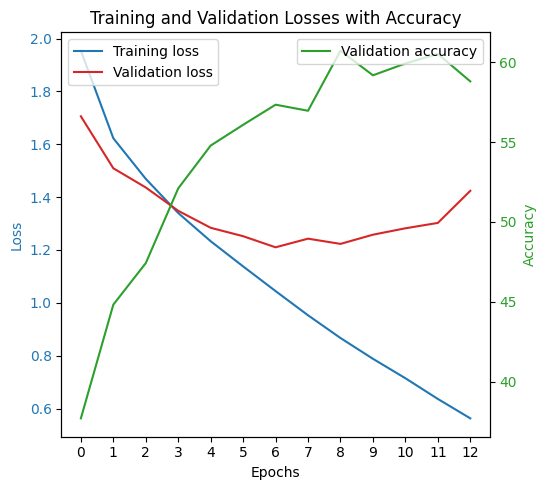

In [18]:
plot_model_performance(baseline_results)

##### Results interpretations :
**Training loss**
- The model keeps fitting the training data better, reducing the training loss. 
This shows that the model is still learning finer details in the training set—even details that might not be helpful for generalization.

**Validation loss and validation accuracy mismatch**
- The divergence between loss and accuracy is not unusual. The loss (e.g., cross-entropy) captures not just whether the predictions are correct, but also how confident the model is. 
- If the model becomes overconfident on the training data (or on a few difficult samples), it can drive the average loss up even while overall accuracy increases.


## LeNet-5

We saw slight overfitting on our baseline model.

Therefore, we will try a LeNet-5 architechture that is slightly more simple :
- 2 Convolutionals layers with 5x5 filters
- 3 FC connected layers

In [19]:
# Define a LeNet-5 model
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        # Define the layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [20]:
#base_model = BaseModel().to(device)
lenet_results = cross_validate(trainset, LeNet5, "LeNet", n_epochs=50)


----- Fold 1 / 5 -----
Epoch 1 - Training loss: 2.1210
Validation loss: 1.9428, Accuracy: 27.90%
Epoch 2 - Training loss: 1.8963
Validation loss: 1.8191, Accuracy: 31.60%
Epoch 3 - Training loss: 1.7612
Validation loss: 1.7098, Accuracy: 34.70%
Epoch 4 - Training loss: 1.6818
Validation loss: 1.6378, Accuracy: 37.80%
Epoch 5 - Training loss: 1.6272
Validation loss: 1.6535, Accuracy: 37.00%
Epoch 6 - Training loss: 1.5811
Validation loss: 1.6489, Accuracy: 37.20%
Epoch 7 - Training loss: 1.5458
Validation loss: 1.5830, Accuracy: 40.90%
Epoch 8 - Training loss: 1.5069
Validation loss: 1.5849, Accuracy: 42.10%
Epoch 9 - Training loss: 1.4608
Validation loss: 1.5121, Accuracy: 42.80%
Epoch 10 - Training loss: 1.4248
Validation loss: 1.5195, Accuracy: 44.50%
Epoch 11 - Training loss: 1.4242
Validation loss: 1.4959, Accuracy: 44.70%
Epoch 12 - Training loss: 1.3854
Validation loss: 1.4735, Accuracy: 44.90%
Epoch 13 - Training loss: 1.3628
Validation loss: 1.5103, Accuracy: 46.30%
Epoch 14 -

In [21]:
# Save model
with open(root+'/content/lenet_results.pkl', 'wb') as f:
    pickle.dump(lenet_results, f)

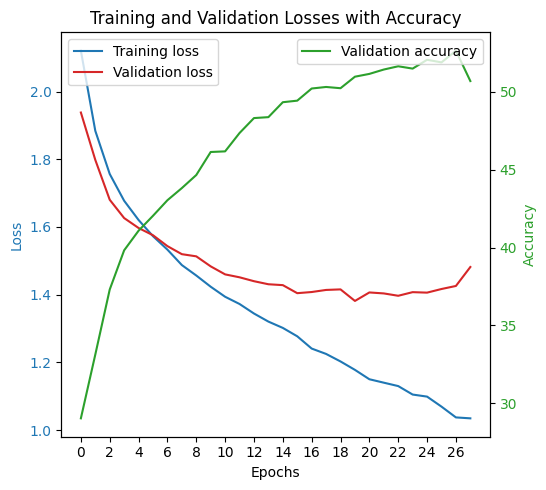

In [22]:
# Plot model performance
plot_model_performance(lenet_results)

##### Results interpretation

**Validation Loss Behavior**
- **Decreases until Epoch 18:** The validation loss steadily decreases up to epoch 18 and then either plateaus or slightly increases, indicating that further training does not lead to improved generalization.
- **Higher Minimum Value:** The simplest model achieves a minimum validation loss of 1.4 compared to 1.25 for the more complex model, suggesting it is not capturing the underlying data patterns as effectively.

**Validation Accuracy Behavior**
- **Increases until Epoch 25:** Validation accuracy improves until around epoch 25, but the maximum accuracy reaches only 53%, which is noticeably lower than the 60% achieved by the other model.
- **Lower Generalization:** The reduced validation accuracy indicates that the simpler model may have limited capacity, resulting in poorer generalization to unseen data.

**Training Loss Behavior**
- **Steady Decrease Across Epochs:** Training loss decreases continuously throughout the epochs, reaching a minimum of 1.0. However, this is higher than the 0.6 achieved by the more complex model.
- **Limited Fitting Capacity:** The higher training loss reflects that the simpler model is not fitting the training data as well, which, along with the lower validation performance, suggests overall underfitting.


## AlexNet

Because the first two models might have been to simple, we will try AlexNet, a deeper model with :
- 2 Convolutional layers with 5x5 filters
- 3 Convolutional layers with 3x3 filters
- 1 Max pooling layer
- 3 Fully Connected layers

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()

        # Define the layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=5, stride=1, padding=2)  # Adjusted for CIFAR-10
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)  # Standard pooling
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1)

        # Compute the correct input size for fully connected layers dynamically
        self.flatten_dim = self._get_conv_output((3, 32, 32))

        self.fc1 = nn.Linear(self.flatten_dim, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)  # Output 10 classes for CIFAR-10

    def _get_conv_output(self, shape):
        """Pass a dummy tensor through conv layers to compute output size."""
        with torch.no_grad():
            x = torch.zeros(1, *shape)  # Create a dummy input tensor
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = F.relu(self.conv3(x))
            x = F.relu(self.conv4(x))
            x = self.pool(F.relu(self.conv5(x)))
            return x.numel()  # Flattened size

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(F.relu(self.conv5(x)))
        x = torch.flatten(x, 1)  # Flatten before FC layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [24]:
alexnet_results = cross_validate(trainset, AlexNet, "AlexNet", n_epochs=50)

# Save model
with open(root+'/content/alexnet_results.pkl', 'wb') as f:
    pickle.dump(alexnet_results, f)


----- Fold 1 / 5 -----
Epoch 1 - Training loss: 2.2137
Validation loss: 2.0156, Accuracy: 20.00%
Epoch 2 - Training loss: 1.9911
Validation loss: 1.8765, Accuracy: 25.00%
Epoch 3 - Training loss: 1.8841
Validation loss: 1.7888, Accuracy: 29.50%
Epoch 4 - Training loss: 1.8082
Validation loss: 1.7270, Accuracy: 35.10%
Epoch 5 - Training loss: 1.7353
Validation loss: 1.6734, Accuracy: 34.40%
Epoch 6 - Training loss: 1.6876
Validation loss: 1.6600, Accuracy: 36.00%
Epoch 7 - Training loss: 1.6480
Validation loss: 1.6360, Accuracy: 34.80%
Epoch 8 - Training loss: 1.6188
Validation loss: 1.5664, Accuracy: 39.40%
Epoch 9 - Training loss: 1.5998
Validation loss: 1.8033, Accuracy: 31.10%
Epoch 10 - Training loss: 1.5622
Validation loss: 1.5622, Accuracy: 39.90%
Epoch 11 - Training loss: 1.5299
Validation loss: 1.5986, Accuracy: 40.90%
Epoch 12 - Training loss: 1.5342
Validation loss: 1.5162, Accuracy: 41.30%
Epoch 13 - Training loss: 1.4837
Validation loss: 1.4905, Accuracy: 45.00%
Epoch 14 -

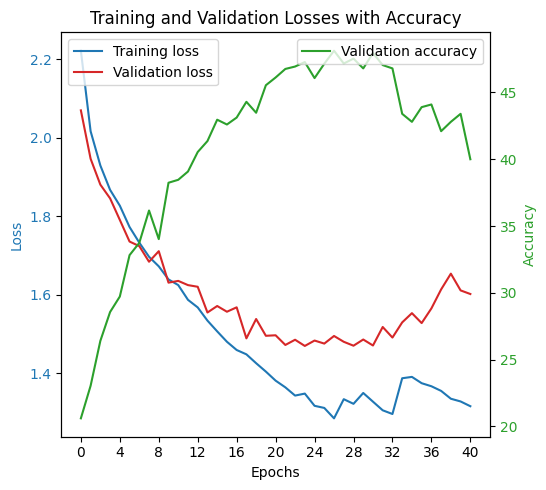

In [25]:
plot_model_performance(alexnet_results)

##### Result interpretations
**Loss Behavior**
- **Training Loss Plateau:** Training loss decreases steadily until about epoch 25 and then plateaus at ~1.25. This indicates that the model has largely extracted the patterns in the training data, but further training doesn't reduce error.
- **Validation Loss Trend:** Validation loss decreases until around epoch 26 and bottoms out at ~1.5. After that, it remains flat or even increases, suggesting that further training does not improve generalization.
- **Extended Training Duration:** The model trains for 40 epochs, which is longer than in simpler models. However, the fact that losses plateau indicates that the additional epochs do not lead to significant improvement.

**Bias-Variance Trade-off**
- **High Bias (Underfitting):** The relatively high training loss (1.25) and low validation accuracy (45%) suggest that the model may be underfitting—it is not complex enough to fully capture the underlying patterns of the CIFAR-10 data.
- **Controlled Variance:** The small gap between training loss and validation loss implies that overfitting (high variance) is not the main issue here.
- **Overall Fit:** The model's inability to push validation performance beyond 45% indicates that its capacity may be limited (high bias), despite its increased complexity compared to simpler models.

**Comparison with Simpler Models**
- **Performance Gap:** Compared to simpler models—which achieved a minimum validation loss of 1.4 and validation accuracy between 53% and 60%—this AlexNet variant shows a higher training loss and a lower validation accuracy. 
This suggests that the more complex architecture is not effectively translating into better performance.
- **Model Capacity vs. Architecture:** The results indicate that simply increasing the number of convolutional layers or using different filter sizes does not guarantee improved learning. The model might need additional mechanisms (e.g., residual connections, batch normalization) or further depth to better capture data complexity.
- **Future Directions:** To improve performance, it may be worthwhile to experiment with a deeper model or to refine the architecture and hyperparameters (such as regularization strategies) to better balance the bias-variance trade-off and fully leverage the model’s learning capacity.
- **Filter size:** from the results obtained on the first model, we think that 3x3 filters will offer better performance, especially because we train on 32x32 images.

## VGG-like deep model

In [50]:
import torch.nn.functional as F

# Define the VGG Block
class VGGBlock(nn.Module):
    """
    VGG-like Block with two convolutional layers and a max pooling layer

    """
    def __init__(self, in_channels, out_channels, kernel_size=3, max_pool=True):
        super(VGGBlock, self).__init__()

        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=1),
            nn.ReLU(inplace=True),
            )
        if max_pool:
            self.block.add_module('MaxPool', nn.MaxPool2d(kernel_size=2, stride=2))

    def forward(self, x):
        return self.block(x)

# Define base model
class VGGNet(nn.Module):
    """
    VGG-like network with 4 VGG blocks and 2 fully connected layers
    """
    def __init__(self):
        super(VGGNet, self).__init__()

        self.model = nn.Sequential(
            VGGBlock(3, 64),
            VGGBlock(64, 128),
            VGGBlock(128, 256),
            VGGBlock(256, 512),
            VGGBlock(512, 512),
            nn.Flatten(),
            nn.Linear(512 * 1 * 1, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 10)
            )

    def forward(self, x):
        return self.model(x)

In [27]:
vgg_results = cross_validate(trainset, VGGNet, "vgg", n_epochs=100)

# Save vgg_results as a pickle file
import pickle
with open(root+'/content/vgg_results.pkl', 'wb') as f:
    pickle.dump(vgg_results, f)


----- Fold 1 / 5 -----
Epoch 1 - Training loss: 2.3038
Validation loss: 2.3046, Accuracy: 9.30%
Epoch 2 - Training loss: 2.3026
Validation loss: 2.3045, Accuracy: 9.30%
Epoch 3 - Training loss: 2.3022
Validation loss: 2.3050, Accuracy: 9.30%
Epoch 4 - Training loss: 2.3023
Validation loss: 2.3043, Accuracy: 9.30%
Epoch 5 - Training loss: 2.3021
Validation loss: 2.3038, Accuracy: 9.30%
Epoch 6 - Training loss: 2.3021
Validation loss: 2.3041, Accuracy: 9.30%
Epoch 7 - Training loss: 2.3020
Validation loss: 2.3040, Accuracy: 9.30%
Epoch 8 - Training loss: 2.3019
Validation loss: 2.3041, Accuracy: 9.30%
Epoch 9 - Training loss: 2.3019
Validation loss: 2.3043, Accuracy: 9.30%
Epoch 10 - Training loss: 2.3019
Validation loss: 2.3042, Accuracy: 9.30%
Early stopping!

----- Fold 2 / 5 -----
Epoch 1 - Training loss: 2.3059
Validation loss: 2.3047, Accuracy: 9.30%
Epoch 2 - Training loss: 2.2182
Validation loss: 2.1268, Accuracy: 17.60%
Epoch 3 - Training loss: 2.0757
Validation loss: 2.0407, A

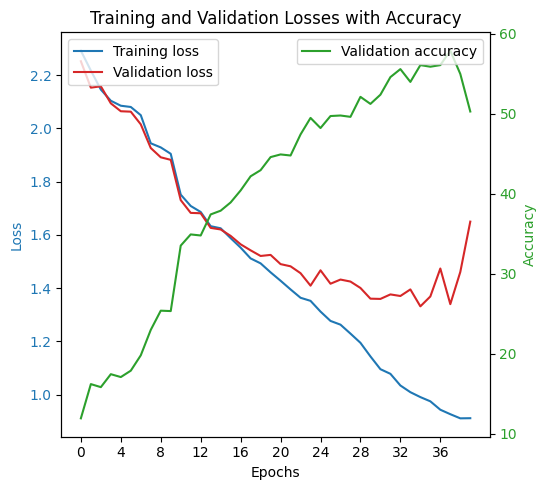

In [28]:
plot_model_performance(vgg_results)

## Residual Nets

We see that the deeper performs better in term of accuracy and validation loss. 

However, the model has some overfitting issues.

Therefore, let's try introducing residual nets and regularization (dropout and batch normalization).

The following model is implemented :
**Convolutional Layers** (all using 3×3 filters):
   - Initial ConvBlock: 1 conv layer (3 → 64)
   - 3 ResidualBlocks with 64 channels: 3 × 2 = 6 conv layers
   - Transition ConvBlock: 1 conv layer (64 → 128)
   - 1 ResidualBlock with 128 channels: 2 conv layers
   Total Convolutional Layers = 1 + 6 + 1 + 2 = 10

**Residual Connections**: 4 (one per ResidualBlock)

**Fully Connected Layers**: 2 (Linear(128*8*8, 32) and Linear(32, 10))

In [51]:
# Define the Convolutional Block
class ConvBlock(nn.Module):
    """
    Convolutional Block with Convolutional, Normalization, ReLU, and Dropout layers
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride, normalize=True, relu=True, dropout=False):
        super(ConvBlock, self).__init__()
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=1, bias=False))
        if normalize:
            layers.append(nn.BatchNorm2d(out_channels))
        if relu:
            layers.append(nn.ReLU(inplace=True))
        if dropout:
            layers.append(nn.Dropout(0.5))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

# Define the Residual Block
class ResidualBlock(nn.Module):
    """
    Residual Block composed of two ConvBlocks.
    A skip (residual) connection adds the block input to its output,
    followed by a ReLU activation.
    """
    def __init__(self, channels, dropout=False):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, stride=1, normalize=True, relu=True, dropout=dropout),
            ConvBlock(channels, channels, kernel_size=3, stride=1, normalize=True, relu=False, dropout=dropout)
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.block(x) + x
        return self.relu(out)

In [ ]:
# Define a deep CNN model with residuals connections
class ResNetModel(nn.Module):
    """
    ResNet-like network with 4 residual blocks and 2 fully connected layers
    """
    def __init__(self):
        super(ResNetModel, self).__init__()
        self.model = nn.Sequential(
            # Initial Conv Block (Conv: 3 -> 64)
            ConvBlock(3, 64, kernel_size=3, stride=1, normalize=True, relu=True),

            # Three Residual Blocks (each with 2 conv layers, 64 channels)
            ResidualBlock(64),
            ResidualBlock(64),
            ResidualBlock(64),

            # Max Pooling reduces spatial size: 32×32 → 16×16
            nn.MaxPool2d(2),

            # Transition Conv Block (Conv: 64 -> 128)
            ConvBlock(64, 128, kernel_size=3, stride=1, normalize=True, relu=True),

            # One Residual Block (2 conv layers, 128 channels)
            ResidualBlock(128),

            # Max Pooling: 16×16 → 8×8
            nn.MaxPool2d(2),

            # Fully Connected Layers
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 10)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
resnet_results = cross_validate(trainset, ResNetModel, "resnet", n_epochs=50, patience=8)
# Save vgg_results as a pickle file
import pickle
with open(root+'/results/resnet_results_3.pkl', 'wb') as f:
    pickle.dump(resnet_results, f)


----- Fold 1 / 1 -----
Epoch 1 - Training loss: 2.8259202412196567
Validation loss: 1.9860245883464813, Accuracy: 30.533333333333335
Epoch 2 - Training loss: 1.7327338734963782
Validation loss: 1.6441905746857326, Accuracy: 36.666666666666664
Epoch 3 - Training loss: 1.554556105369912
Validation loss: 1.5292911231517792, Accuracy: 45.46666666666667
Epoch 4 - Training loss: 1.4513400775149352
Validation loss: 1.4498861978451412, Accuracy: 48.13333333333333
Epoch 5 - Training loss: 1.3759090568786276
Validation loss: 1.3894769450028737, Accuracy: 50.93333333333333
Epoch 6 - Training loss: 1.3127648785598296
Validation loss: 1.3682843148708344, Accuracy: 51.733333333333334
Epoch 7 - Training loss: 1.2574264438528764
Validation loss: 1.368135963877042, Accuracy: 48.53333333333333
Epoch 8 - Training loss: 1.1741915986053926
Validation loss: 1.2719463308652241, Accuracy: 56.0
Epoch 9 - Training loss: 1.1457904214249517
Validation loss: 1.3471362193425496, Accuracy: 51.86666666666667
Epoch 1

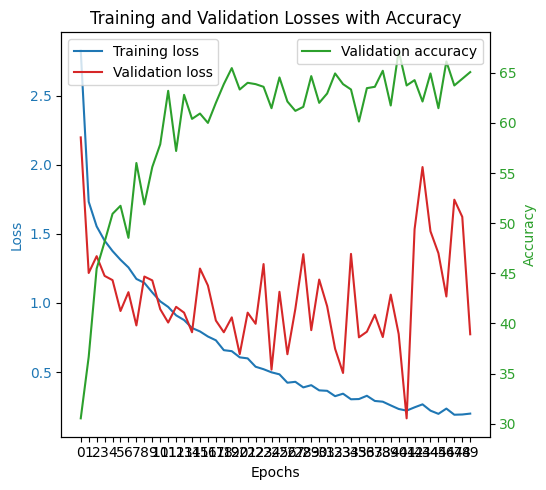

In [ ]:
plot_model_performance(resnet_results)

##### Result interpretation

## Deeper Model (20 layers)

Let's test another deeper model (with 20 layers compared to the 10-layers deep previous model)/

This time, we will also apply dropout and batch normalization.

In [ ]:
# Define a deep CNN model with residuals connections
class DeepResNetModel(nn.Module):
    """
    ResNet-like network with 4 residual blocks and 2 fully connected layers
    """
    def __init__(self):
        super(DeepResNetModel, self).__init__()
        self.model = nn.Sequential(
            # Initial Conv Block (Conv: 3 -> 64)
            ConvBlock(3, 64, kernel_size=3, stride=1, normalize=True, relu=True),

            # Group 1: 4 Residual Blocks (each with 2 conv layers, 64 channels)
            ResidualBlock(64),
            ResidualBlock(64),
            ResidualBlock(64),
            ResidualBlock(64),

            # Max Pooling: reduces 32×32 → 16×16
            nn.MaxPool2d(2),

            # Transition Conv Block (Conv: 64 -> 128)
            ConvBlock(64, 128, kernel_size=3, stride=1, normalize=True, relu=True),

            # Group 2: 5 Residual Blocks (each with 2 conv layers, 128 channels)
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),

            # Max Pooling: reduces 16×16 → 8×8
            nn.MaxPool2d(2),

            # Fully Connected Layers
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 10)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# Train the model
deep_resnet_results = cross_validate(trainset, DeepResNetModel, "deep_resnet", n_epochs=50, patience=8)

# Save the results
with open(root+'/results/deep_resnet_results.pkl', 'wb') as f:
    pickle.dump(deep_resnet_results, f)

In [ ]:
plot_model_performance(deep_resnet_results)

##### Result interpretation

# DenseNet

Now, another modern CNN architechture is the DenseNet. This is a model where Convolution layers are densely connected.

Model architechture :

- Initial Convolution:
    * Input: 3 channels
    * Output: 2 * growth_rate channels (e.g. 24 channels for growth_rate=12)

- Dense Block 1:
    * Contains num_layers layers; each layer adds growth_rate channels.
    * Output channels = 2*growth_rate + num_layers*growth_rate.
      (For growth_rate=12 and num_layers=12: 24 + 144 = 168)

- Transition Block 1:
    * Compresses channels: out_channels = int((2*growth_rate + num_layers*growth_rate) * theta)
      (For theta=0.5: int(168 * 0.5) = 84)

- Dense Block 2:
    * Input channels: 84; output channels = 84 + num_layers*growth_rate.
      (84 + 144 = 228)

- Transition Block 2:
    * Output channels = int(228 * theta) → 114 channels.

- Dense Block 3:
    * Input channels: 114; output channels = 114 + num_layers*growth_rate.
      (114 + 144 = 258)

- Transition Block 3:
    * Output channels = int(258 * theta) → 129 channels.

- Dense Block 4:
    * Input channels: 129; output channels = 129 + num_layers*growth_rate.
      (129 + 144 = 273)

- Classifier:
    * Global average pooling to 1×1 and a linear layer from final channel count to 10 classes.

In [52]:
# Define the Dense Block (with concatenation)
class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers):
        super(DenseBlock, self).__init__()
        self.num_layers = num_layers
        self.layers = nn.ModuleList()
        # Each layer will receive the concatenation of all previous features.
        for i in range(num_layers):
            self.layers.append(self.add_block(in_channels + i * growth_rate, growth_rate))
    
    def add_block(self, in_channels, growth_rate):
        return nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1, bias=False)
        )
    
    def forward(self, x):
        features = [x]
        for layer in self.layers:
            # Concatenate along the channel dimension
            new_feature = layer(torch.cat(features, dim=1))
            features.append(new_feature)
        return torch.cat(features, dim=1)

# Define the Transition Block (for compression and downsampling)
class TransitionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionBlock, self).__init__()
        self.block = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
    
    def forward(self, x):
        return self.block(x)

# Define the DenseNet model
class DenseNet(nn.Module):
    def __init__(self, growth_rate=12, num_layers=12, theta=0.5):
        super(DenseNet, self).__init__()
        k = growth_rate
        L = num_layers

        # Initial convolution
        self.conv = nn.Conv2d(in_channels=3, out_channels=2*k, kernel_size=3, padding=1, bias=False)
        init_channels = 2 * k

        # Dense Block 1 and Transition 1
        dense1_out = init_channels + L * k       # 2*k + L*k
        trans1_out = int(dense1_out * theta)
        self.dense1 = DenseBlock(init_channels, k, L)
        self.trans1 = TransitionBlock(dense1_out, trans1_out)

        # Dense Block 2 and Transition 2
        dense2_in = trans1_out
        dense2_out = dense2_in + L * k
        trans2_out = int(dense2_out * theta)
        self.dense2 = DenseBlock(dense2_in, k, L)
        self.trans2 = TransitionBlock(dense2_out, trans2_out)

        # Dense Block 3 and Transition 3
        dense3_in = trans2_out
        dense3_out = dense3_in + L * k
        trans3_out = int(dense3_out * theta)
        self.dense3 = DenseBlock(dense3_in, k, L)
        self.trans3 = TransitionBlock(dense3_out, trans3_out)

        # Dense Block 4 (no transition after)
        dense4_in = trans3_out
        dense4_out = dense4_in + L * k
        self.dense4 = DenseBlock(dense4_in, k, L)

        # Classifier: Global average pooling then linear layer to 10 classes
        self.fc = nn.Linear(dense4_out, 10)

    def forward(self, x):
        x = F.relu(self.conv(x))
        x = self.trans1(self.dense1(x))
        x = self.trans2(self.dense2(x))
        x = self.trans3(self.dense3(x))
        x = self.dense4(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [ ]:
densenet_results = cross_validate(trainset, DenseNet, "DenseNet", n_epochs=50)

# Save model
with open(root+'/results/densenet_results_2.pkl', 'wb') as f:
    pickle.dump(densenet_results, f)

In [ ]:
plot_model_performance(densenet_results)

# Conclusion

#### **1. Impact of Architecture on Bias-Variance Trade-Off**

##### **Baseline Model:**
- The model learns quickly and reaches a reasonable accuracy (~0.61).
- However, the evaluation loss stops improving after epoch 8, while the training loss continues to drop, indicating **overfitting**.
- This suggests that the model is **too simple** and lacks capacity to generalize well.

##### **VGG-like Model (Deep Convolutional Network):**
- Shows a steady improvement in accuracy and loss over a longer training period.
- The accuracy follows a **logarithmic growth pattern**, meaning the model benefits from deep layers but requires **longer training**.
- The fact that the evaluation loss plateaus at epoch 20 suggests that the model **might be overfitting**, as training loss keeps decreasing.
- **Deep networks** like VGG tend to have **high variance** but also strong representational power.

##### **ResNet-like Model (Deep Residual Network):**
- Initially has **higher loss** compared to other models but **maintains a steady decrease in evaluation loss** along with training loss.
- **Residual connections** likely help combat vanishing gradients, allowing for **better feature learning** over deeper layers.
- The evaluation accuracy also follows a **logarithmic pattern**, similar to VGG but with potentially better **generalization**.

---

#### **2. Interpretation of Training Results**
- All models eventually **converge around 0.61 accuracy**, suggesting that **architecture alone is not the limiting factor**.
- The **baseline model** improves quickly but overfits, suggesting **high bias** but **low variance**.
- The **VGG model** improves slower but has the capacity to reach a similar accuracy, though it likely suffers from **high variance** (overfitting).
- The **ResNet model** improves steadily and maintains a **decreasing evaluation loss**, suggesting **better generalization**.

---

#### **3. Choosing the Best Model**
- **For quick training & reasonable accuracy:** The **baseline model** is a good choice.
- **For high representational power but higher risk of overfitting:** The **VGG model** is suitable.
- **For deep networks with better generalization:** The **ResNet model** is the most promising.

Considering **CIFAR-10** is a relatively **complex dataset with 10 classes**, and **deep learning models benefit from residual learning**,  
the **ResNet-like model appears to be the best choice**, given its ability to maintain **decreasing evaluation loss** and **generalize better**.

# Pre-trained Models

We will compare our results with using pre-trained deep convolution networks, with a fine-tuned output layer (suited to the task at hand).

### VGG-19

In [ ]:
def pre_trained_model(pre_trained_model):
    # Instantiate VGG19
    if pre_trained_model == "vgg19":
        from torchvision.models import VGG19_Weights
        model = torchvision.models.vgg19(weights=VGG19_Weights.DEFAULT)
        # Change model output layer to handle 10 target classes
        model.classifier[6] = nn.Linear(4096, 10)
        # Freeze the model parameters
        for param in model.parameters():
            param.requires_grad = False
        # Unfreeze the last layer
        for param in model.classifier[6].parameters():
            param.requires_grad = True
        return model

     
    # Instantiate 
    elif pre_trained_model == "resnet50":
        from torchvision.models import ResNet50
        model = torchvision.models.resnet50(pretrained=True)    
        # Change model output
        model.fc = nn.Linear(2048, 10)  
        # Freeze the model parameters
        for param in model.parameters():
          param.requires_grad = False   
        for param in model.fc.parameters():
          param.requires_grad = True
          
        return model
    
    return None

In [ ]:
# Load the VGG19 model
from torchvision.models import VGG19_Weights
vgg19 = torchvision.models.vgg19(weights=VGG19_Weights.DEFAULT)

# Change model output layer to handle 10 target classes
vgg19.classifier[6] = nn.Linear(4096, 10)

# Freeze the model parameters
for param in vgg19.parameters():
    param.requires_grad = False

# Unfreeze the last layer
for param in vgg19.classifier[6].parameters():
    param.requires_grad = True

In [ ]:
vgg19_results = cross_validate(trainset, None, "vgg19", n_epochs=20, pre_trained_model=vgg19, pre_trained=True)

# Save vgg_results as a pickle file
import pickle
with open(root+'/results/vgg19_results.pkl', 'wb') as f:
    pickle.dump(vgg19_results, f)


----- Fold 1 / 2 -----
Epoch 1 - Training loss: 2.4068908305992758
Validation loss: 1.8445728421211243, Accuracy: 48.8
Epoch 2 - Training loss: 1.0108813517972042
Validation loss: 1.7490586539109547, Accuracy: 46.8
Epoch 3 - Training loss: 0.9392447027944981
Validation loss: 1.693501169482867, Accuracy: 47.733333333333334
Epoch 4 - Training loss: 0.9794496181315946
Validation loss: 1.7028820514678955, Accuracy: 46.0
Epoch 5 - Training loss: 1.001818919540348
Validation loss: 1.6521981606880825, Accuracy: 47.333333333333336
Epoch 6 - Training loss: 0.9530802678344841
Validation loss: 1.745103433728218, Accuracy: 47.86666666666667
Epoch 7 - Training loss: 0.989244421397833
Validation loss: 1.684599834183852, Accuracy: 48.53333333333333
Epoch 8 - Training loss: 0.9704236365798721
Validation loss: 1.7258092164993286, Accuracy: 46.4
Epoch 9 - Training loss: 0.9716006781821861
Validation loss: 1.72224157055219, Accuracy: 46.4
Epoch 10 - Training loss: 1.0039507069982083
Validation loss: 1.6

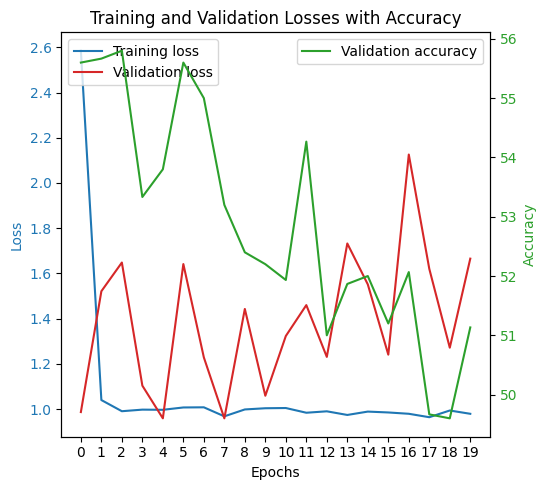

In [ ]:
plot_model_performance(vgg19_results)

### **Conclusion: Evaluating the Pre-Trained VGG19 on CIFAR-10**

#### **1. Observations from the Pre-Trained VGG19 Experiment**
- The **training loss stagnates after 6 epochs**, stopping at **0.97** and failing to decrease further.
- The **evaluation loss remains constant**, indicating that the model is **not learning effectively** from the CIFAR-10 dataset.
- The **evaluation accuracy hovers around 48%**, significantly lower than the **61% achieved by models trained from scratch**, suggesting **poor generalization**.

---

#### **2. Why VGG19 is Not Well-Suited for CIFAR-10**
1. **Pre-Trained on a Different Dataset (ImageNet)**  
   - VGG19 was originally trained on **ImageNet**, which consists of **high-resolution** images with **1,000 categories**.  
   - CIFAR-10, on the other hand, consists of **low-resolution (32x32) images** with only **10 classes**.  
   - The **learned features** from ImageNet **may not transfer well** to CIFAR-10, leading to poor performance.

2. **Mismatch in Feature Representation**  
   - VGG19's early layers are optimized for detecting **complex patterns** in high-resolution images, such as textures and fine-grained details.  
   - CIFAR-10 images lack such intricate details, so the **feature extraction process might not be optimal**.  

3. **Overparameterization & Poor Fine-Tuning**  
   - VGG19 is a **very deep network (19 layers)** with **millions of parameters**, making it prone to **overfitting** on a small dataset like CIFAR-10.  
   - If only the last layer was fine-tuned, the **rest of the network remained frozen**, preventing effective adaptation to CIFAR-10.  
   - The network **failed to learn task-specific features**, leading to stagnation in both training and evaluation loss.  

---

#### **3. Comparison with Training from Scratch**
- The **VGG-like model trained from scratch** on CIFAR-10 reached **61% accuracy**, showing **better adaptation** to the dataset.
- The **pre-trained VGG19**, despite leveraging transfer learning, only reached **48% accuracy**, highlighting its **ineffectiveness** for this task.
- This suggests that **training from scratch on CIFAR-10 is more effective** than using a **pre-trained model that was trained on a different domain**.

---

#### **4. Final Takeaway**
- **Using a pre-trained model is not always beneficial**, especially if the source dataset differs significantly from the target dataset.  
- For **low-resolution datasets like CIFAR-10**, models specifically trained on similar data **perform better than transferring knowledge from high-resolution datasets**.  
- A better alternative to VGG19 would be **pre-trained models specifically designed for small datasets**, such as **WideResNet or EfficientNet-B0**, which have shown better transferability for CIFAR-10.

### ResNet50

In [61]:
# Import pre-trained weights
from torchvision.models import ResNet50_Weights

# Load the ResNet50 model
resnet50 = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)

# Change model output layer to handle 10 target classes
resnet50.fc = nn.Linear(2048, 10)

# Freeze the model parameters
for param in resnet50.parameters():
    param.requires_grad = False

# Unfreeze the last layer
for param in resnet50.fc.parameters():
    param.requires_grad = True

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/theopinto--dalle/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100.0%


In [ ]:
resnet50_results = cross_validate(trainset, None, "resnet50", n_epochs=20, pre_trained_model=resnet50, pre_trained=True)

# Save resnet50_results as a pickle file
import pickle
with open(root+'/results/resnet50_results.pkl', 'wb') as f:
    pickle.dump(resnet50_results, f)


----- Fold 1 / 2 -----
Epoch 1 - Training loss: 2.128219306917119
Validation loss: 2.042494922876358, Accuracy: 34.13333333333333
Epoch 2 - Training loss: 2.3565654315446554
Validation loss: 2.546196093161901, Accuracy: 34.666666666666664
Epoch 3 - Training loss: 2.179969000637083
Validation loss: 2.0743167648712793, Accuracy: 35.6
Epoch 4 - Training loss: 2.277139947826701
Validation loss: 2.1444531977176666, Accuracy: 36.266666666666666
Epoch 5 - Training loss: 2.2054397011161746
Validation loss: 2.1097868531942368, Accuracy: 36.266666666666666
Epoch 6 - Training loss: 2.194853196466776
Validation loss: 2.0896421521902084, Accuracy: 36.0
Epoch 7 - Training loss: 1.986299357019869
Validation loss: 2.0579458524783454, Accuracy: 37.86666666666667
Epoch 8 - Training loss: 1.9831772137405281
Validation loss: 1.9505397776762645, Accuracy: 40.266666666666666
Epoch 9 - Training loss: 1.960639967057938
Validation loss: 1.9132600476344426, Accuracy: 36.8
Epoch 10 - Training loss: 2.1050231017

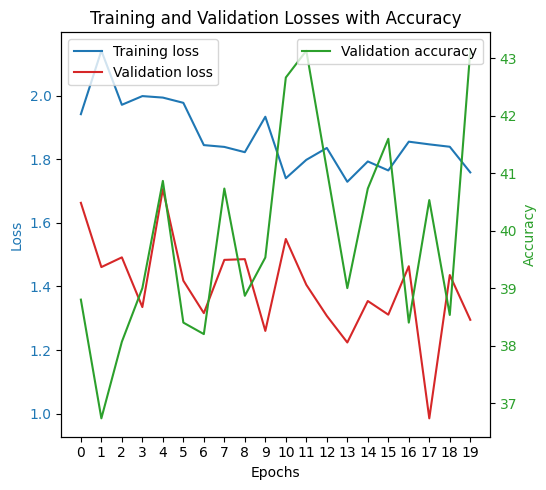

In [ ]:
plot_model_performance(resnet50_results)